In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import re
import datetime
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
from collections import Counter
import math
import ast
import re
from datetime import datetime
from dateutil.parser import parse
import missingno as msno
import rest_func as rf



# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 45
CURRENT_DATE = pd.to_datetime('19/08/2020')

## DATA

In [3]:
df = pd.read_csv('main_task.csv')

In [4]:
df.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
18527,id_1976,Madrid,NaN,1978.0,4.5,NaN,28.0,"[['Great Tapas'], ['04/05/2017']]",/Restaurant_Review-g187514-d6516122-Reviews-Ba...,d6516122
33117,id_8149,Madrid,['Spanish'],8156.0,2.5,$$ - $$$,13.0,"[['Paella Valenciana', 'Average food, unfriend...",/Restaurant_Review-g187514-d10517559-Reviews-C...,d10517559
19740,id_182,Bratislava,"['American', 'Grill']",183.0,5.0,$,7.0,"[['Funtastic burgers', 'Wow! Good value for mo...",/Restaurant_Review-g274924-d11886627-Reviews-T...,d11886627
39263,id_4892,Milan,['Italian'],4895.0,4.0,$$ - $$$,14.0,"[[], []]",/Restaurant_Review-g187849-d8601298-Reviews-Ty...,d8601298
33302,id_3216,Milan,['Italian'],3218.0,4.5,NaN,18.0,"[[], []]",/Restaurant_Review-g187849-d4053843-Reviews-Pi...,d4053843


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


## Создадим функции

In [6]:
# Создаем функцию для перевода ценового диапазона в числовое значение
def price_range(row):
    if row['Price Range'] == '$':
        return 1
    elif row['Price Range'] == '$$ - $$$':
        return 2
    elif row['Price Range'] == '$$$$':
        return 3
    else:
        return 0

# Функция подсчета количества кухонь в каждом ресторане


def filter_cuisine_style(line):
    if pd.isnull(line):
        return ['one']
    else:
        line = line.replace('[','')
        line = line.replace(']', '')
        line = line.strip()
        line = [style.strip() for style in line.split(',')]
        line = [style for style in line if len(style) > 0]
        return line
    
def calculate_cuisines(row):
    return len(row['Cuisine Style'].split(','))

#Обработка отзывов
def reviews_to_list(line):
    if pd.isnull(line):
        return ['one']
    else:
        line = line.replace(']]', '')
        line = line.replace("'", '')
        line = line.split('], [')[1]
        line = line.split(', ')
        return line



## Data

Подробнее по признакам:

* City: Город  
* Cuisine Style: Кухня  
* Ranking: Ранг ресторана относительно других ресторанов в этом городе  
* Price Range: Цены в ресторане в 3 категориях  
* Number of Reviews: Количество отзывов  
* Reviews: 2 последних отзыва и даты этих отзывов  
* URL_TA: страница ресторана на 'www.tripadvisor.com'  
* ID_TA: ID ресторана в TripAdvisor  
* Rating: Рейтинг ресторана  

Проверим данные на пропуски:


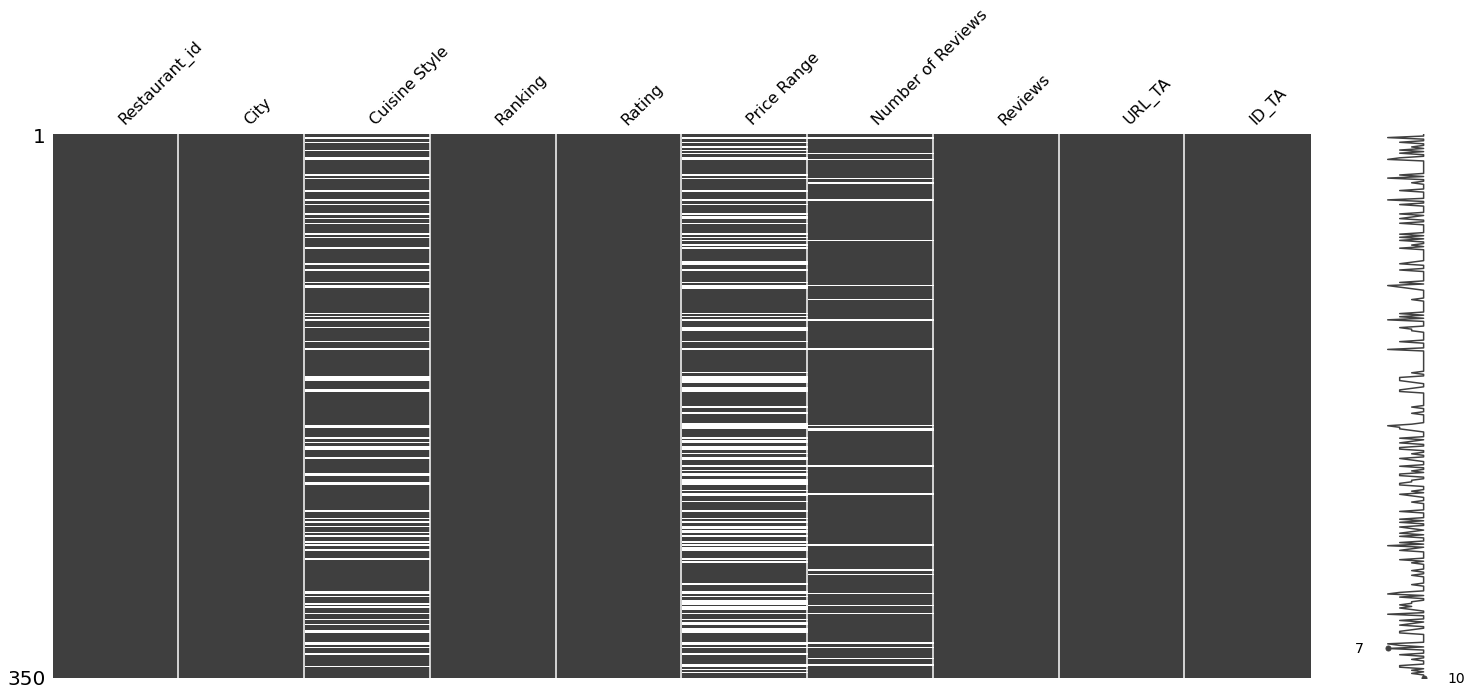

In [7]:
msno.matrix(df.sample(350))

На графике видны пропуски только в 3-х переменных: Cuisine Style, Price Range, Reviews

Oпределим типы данных

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


**Данные отсутствуют в :**

* Cuisine Style  
* Price Range  
* Number of Reviews  

**Категориальные данные:**

* Restaurant_id  
* City  
* Cuisine Style  
* Price Range  
* URL_TA  
* ID_TA  

**Числовой формат данных:**

* Ranking  
* Number of Reviews  
* Rating  

Посмотрим , как распределяется целевая переменная

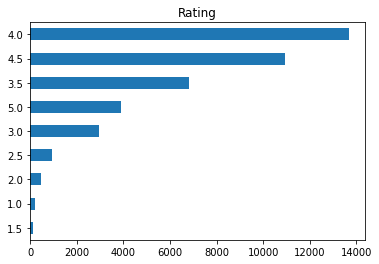

In [9]:
df['Rating'].value_counts(ascending=True).plot(kind='barh', title= 'Rating')

Больше половины ресторанов имеют рейтинг 4 и выше

Теперь посмотрим распределение по городам :

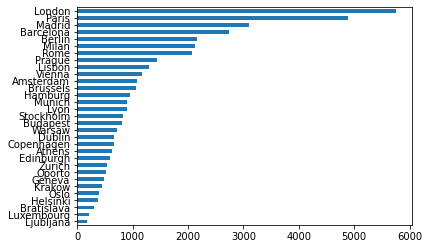

In [10]:
df['City'].value_counts(ascending=True).plot(kind='barh')

Четверка лидеров: Лондон,Париж,Мадрид,Барселона. 
Посмотрим распределение в Париже 

Топ 10 городов

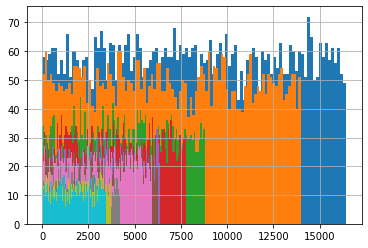

In [11]:
for x in (df['City'].value_counts())[0:10].index:
    df['Ranking'][df['City'] == x].hist(bins=100)
plt.show()

То есть распределение примерно одинаковое, но чем больше город , тем больше ресторанов (что ж , вполне логично)

Распределение целевой переменной относительно признака

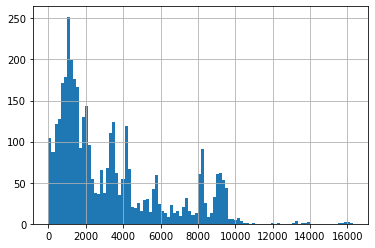

In [12]:
df['Ranking'][df['Rating'] == 5].hist(bins=100)

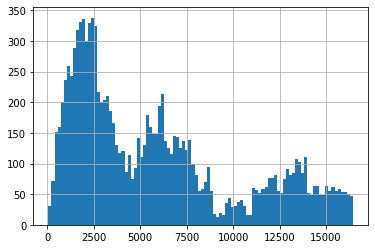

In [13]:
df['Ranking'][df['Rating'] < 4].hist(bins=100)

## Очистка данных и заполнение пропусков

Заполным Couisine Style каким-нибудь словом ,например "one" . Number of Reviews нулями из предположения ,что если данных нет, то нет и отзывов 

In [14]:
df['Number of Reviews'].fillna(0, inplace=True)

In [15]:
df['Cuisine Style'].fillna("['one']", inplace=True)

Restaurant_id aявно не несёт никакой дополнительной информации и коррелирует с Ranking - удалим его

In [16]:
df.drop(['Restaurant_id'], axis=1, inplace=True)

## Создание нoвых признаков

Для начала создадим словари , которые будем использовать


In [17]:
# Словарь стран для каждого города 
countries = {
'London' : 'uk' ,
'Edinburgh' : 'uk',
'Paris': "france",
'Lyon' : "france", 
'Madrid' :"spain",
'Barcelona':"spain",
'Berlin' :"germany" ,
'Hamburg': "germany" ,
'Munich' : "germany" ,
'Rome' :"italy" ,
'Milan' :"italy",
'Prague' : "czech " ,
'Lisbon' : "portugal",
'Oporto' :"portugal",
'Vienna': "austria",
'Amsterdam' : "netherlands",
'Brussels' : "belgium",
'Stockholm' : "sweden",
'Budapest' : "hungary" ,
'Warsaw' : "poland",
'Krakow' : "poland",
'Dublin' : "ireland",
'Zurich' : "swiss",
'Geneva' : "swiss",
'Oslo' : "norway" ,
'Helsinki' : "finland" ,
'Bratislava' : "slovakia",
'Luxembourg' : "luxembourg" ,
'Ljubljana' :"slovenia",
'Athens' : 'greece',
'Copenhagen' : 'denmark'
}

# Словарь общих определений  для всех типов кухонь в датасете 
cuisine_type = {
"European":"national",
"French":"national",
"International":"national",
"Japanese":"national",
"Asian":"national",
"German":"national",
"Central European":"national",
"Italian":"national",
"Mediterranean":"national",
"Spanish":"national",
"Thai":"national",
"Vietnamese":"national",
"Chinese":"national",
"British":"national",
"Polish":"national",
"Dutch":"national",
"Mexican":"national",
"Venezuelan":"national",
"South American":"national",
"Belgian":"national",
"Latin":"national",
"Argentinean":"national",
"Irish":"national",
"Swiss":"national",
"Portuguese":"national",
"Greek":"national",
"Central American":"national",
"Indian":"national",
"Middle Eastern":"national",
"Turkish":"national",
"Hungarian":"national",
"Pakistani":"national",
"Peruvian":"national",
"Eastern European":"national",
"Swedish":"national",
"Scandinavian":"national",
"Tibetan":"national",
"Nepali":"national",
"Korean":"national",
"Southwestern":"national",
"Czech":"national",
"American":"national",
"Slovenian":"national",
"Balti":"national",
"Caribbean":"national",
"Austrian":"national",
"Moroccan":"national",
"Lebanese":"national",
"African":"national",
"Ethiopian":"national",
"Egyptian":"national",
"Danish":"national",
"Brazilian":"national",
"Ecuadorean":"national",
"Israeli":"national",
"Australian":"national",
"Singaporean":"national",
"Malaysian":"national",
"Minority Chinese":"national",
"Scottish":"national",
"Arabic":"national",
"Ukrainian":"national",
"Chilean":"national",
"Mongolian":"national",
"Cuban":"national",
"Persian":"national",
"Indonesian":"national",
"Colombian":"national",
"Jamaican":"national",
"Norwegian":"national",
"Hawaiian":"national",
"Armenian":"national",
"Taiwanese":"national",
"Bangladeshi":"national",
"Sri Lankan":"national",
"Cambodian":"national",
"Albanian":"national",
"New Zealand":"national",
"Croatian":"national",
"Central Asian":"national",
"Filipino":"national",
"Tunisian":"national",
"Cajun & Creole":"national",
"Romanian":"national",
"Georgian":"national",
"Polynesian":"national",
"Azerbaijani":"national",
"Caucasian":"national",
"Afghani":"national",
"Uzbek":"national",
"Salvadoran":"national",
"Yunnan":"national",
"Native American":"national",
"Canadian":"national",
"Xinjiang":"national",
"Burmese":"national",
"Fujian":"national",
"Welsh":"national",
"Latvian":"national",
"Russian":"national",
"Kosher":"religious",
"Halal":"religious",
"Bar":"bar",
"Pub":"bar",
"Wine Bar":"bar",
"Brew Pub":"bar",
"Gastropub":"bar",
"Sushi":"fast_food",
"Pizza":"fast_food",
"Fast Food":"fast_food",
"Street Food":"fast_food",
"Grill":"meat",
"Steakhouse":"meat",
"Seafood":"fish",
"Barbecue":"meat",
"Vegetarian Friendly":"vegi",
"Vegan Options":"vegi",
"Vegan Options":"healthy",
"Gluten Free Options":"vegi",
"Cafe":"common",
"Soups":"common",
"Diner":"common",
"Fusion":"special",
"Contemporary":"special",
"Delicatessen":"special",
"one":"none"
}

# Словарь количества ресторанов для каждой страны 
# присутствующей в датасете (Внешний источник - 2018 )
rest_num  = {
"uk": 83622,
"france" : 169338 , 
"spain" : 75591,
"germany" : 133555,
"italy" : 146089 ,
"czech " : 48241,
"portugal" : 29893,
"austria" : 27754,
"netherlands" : 28750 ,
"belgium" : 28029,
"sweden" : 24953,
"hungary" : 16514,
"poland" : 27829,
"ireland" : 7570,
"swiss" : 5850 ,
"norway" : 6600,
"finland" : 7848,
"slovakia" : 10692,
"luxembourg" : 1430,
"slovenia" : 4478,
"greece" : 43766,
"denmark" :8537
}

# Количество ресторанов Мишлен в каждом городе (Внешний источник - 2018 )
michelin_rest = {
'London' : 380 ,
'Edinburgh' : 22,
'Paris': 453,
'Lyon' : 75 , 
'Madrid' : 97,
'Barcelona': 61,
'Berlin' : 66,
'Hamburg': 63,
'Munich' : 61 ,
'Rome' : 54,
'Milan' : 87,
'Prague' : 27,
'Lisbon' : 21,
'Oporto' : 11,
'Vienna': 58,
'Amsterdam' : 75,
'Brussels' : 43,
'Stockholm' : 46,
'Budapest' : 22,
'Warsaw' : 20,
'Krakow' : 19,
'Dublin' : 17,
'Zurich' : 76,
'Geneva' : 58,
'Oslo' : 29,
'Helsinki' : 29,
'Bratislava' : 0,
'Luxembourg' : 41,
'Ljubljana' : 15,
'Athens' : 20,
'Copenhagen' : 63
}

# Количество туристов посещающих каждый из городов (Внешний источник - 2018 )

city_tourists = {
'London' : 19233000 ,
'Edinburgh' : 1660000,
'Paris': 17560200,
'Lyon' : 6200000 , 
'Madrid' : 5440100,
'Barcelona': 6714500,
'Berlin' : 5959400,
'Hamburg': 1450000,
'Munich' : 4066600 ,
'Rome' : 10065400,
'Milan' : 6481300,
'Prague' : 8948600,
'Lisbon' : 3539400,
'Oporto' : 2341300,
'Vienna': 6410300,
'Amsterdam' : 8354200,
'Brussels' : 3942000,
'Stockholm' : 2604600,
'Budapest' : 3822800,
'Warsaw' : 2850000,
'Krakow' : 2732000,
'Dublin' : 5213400,
'Zurich' : 2240000,
'Geneva' : 1150000,
'Oslo' : 1400000,
'Helsinki' : 5300000,
'Bratislava' : 5400000,
'Luxembourg' :1046000 ,
'Ljubljana' : 5900000,
'Athens' : 5728400,
'Copenhagen' : 3069700
}

# Уровень безработицы по странам (Внешний источник - 2018 )
unemp_city_rate = {
'London' : 5.1 ,
'Edinburgh' : 3.8,
'Paris': 8.8,
'Lyon' : 7.3 , 
'Madrid' : 12.2,
'Barcelona': 11.5,
'Berlin' : 6.1,
'Hamburg': 4.1,
'Munich' : 2.3 ,
'Rome' : 11.1,
'Milan' : 6.0,
'Prague' : 1.3,
'Lisbon' : 7.4,
'Oporto' : 7.3,
'Vienna': 10.0,
'Amsterdam' : 3.8,
'Brussels' : 13.2,
'Stockholm' : 5.8,
'Budapest' : 3.1,
'Warsaw' : 2.4,
'Krakow' : 3.3,
'Dublin' : 5.8,
'Zurich' : 4.3,
'Geneva' : 7.5,
'Oslo' : 4.2,
'Helsinki' : 6.9,
'Bratislava' : 2.9,
'Luxembourg' :5.4 ,
'Ljubljana' : 4.7,
'Athens' : 18.9,
'Copenhagen' : 5.3
}

Пойдем по порядку и приведем ценовой разброс к числовому значению , при этом отсутствующим значениям присвоим ноль

In [18]:
df['price_range'] = df.apply(rf.price_range, axis=1)

Посчитаем количество кухонь в каждом ресторане

In [19]:
df['num_cuisines'] = df.apply(calculate_cuisines, axis=1)

Чтобы не слишком загружать модель добавим страну для каждого города и из стран создадим dummy с помощью функции get_dummies

In [20]:
df['country'] = df['City'].map(countries)
dummy = pd.get_dummies(df['country'])
df = pd.concat([df,dummy],axis = 1)

Так же как и с городами , воспользуемся  словарем с целью создания груп кухонь, что , по идее , должно  улучшить точность модели 

In [21]:
df1 = df
df1['Cuisine Style'] = df1['Cuisine Style'].apply(rf.filter_cuisine_style)
df1 = df1.explode(column='Cuisine Style')
df1['cuisine_type'] = df1['Cuisine Style'].str.strip("'").map(cuisine_type)
dummy2 = pd.get_dummies(df1['cuisine_type']).max(level=0)
df = pd.concat([df,dummy2],axis = 1)

Из внешних источников , получим общее количество ресторанов для каждой страны . Вполне ввероятно , что это может повлиять на точность нашего предсказания.

In [22]:
df['rest_num'] = df.country.map(rest_num)

Опять же, из внешних источников добавим количество ресторанов из справочника Мишлен для каждого города (они-то точно знают , где  больше хороших ресторанов)

In [23]:
df['michelin_rest'] = df['City'].map(michelin_rest)

Теперь, посчитаем общее количество ресторанов в каждом городе  и вычислим процент ресторанов "Мишлен" в каждом из них 

In [24]:
df_tmp = df['City'].value_counts()
df['city_rest_counts'] = df['City'].apply(lambda x: df_tmp[x])
df['michelin_rate'] = df['michelin_rest']/df['city_rest_counts']

Проверим сколько туристов посещает в течении года каждый из городов и вычислим соотношение туристов на ресторан в городе (чем выше количество туристов посещающих ресторан тем выше вероятность получить низкий рейтинг - всегда найдется достаточное количество недовольных )

In [25]:
df['city_tourists'] = df['City'].map(city_tourists)
df['rest_by_tourists'] = df['city_rest_counts']/df['city_tourists']

В довершение, проверим уровень безработицы по городам - чем выше уровень , тем лучше должно быть обслуживание ( кому хочется быть уволенным , если работы не так-то просто найти)

In [26]:
df['unemp_city_rate'] = df['City'].map(unemp_city_rate)

Посчитаем процентное соотношение ресторанов по городам

In [27]:
df['pr_country_rest'] = df['city_rest_counts']/df['rest_num']

**Что получилось на данный момент ?**

Удалим все категориальные признаки

In [28]:
object_columns = [s for s in df.columns if df[s].dtypes == 'object']
df.drop(object_columns, axis=1, inplace = True)

Построим корреляционную матрицу и проверим отношения между признаками 

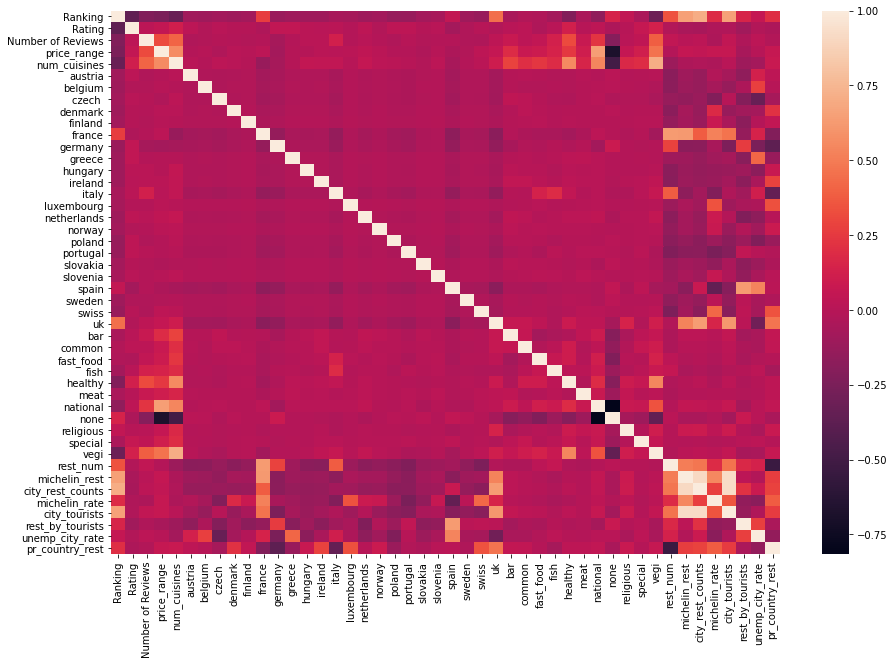

In [29]:
plt.rcParams['figure.figsize'] = (15, 10)
sns.heatmap(df.corr())

Можно заметить , что существует довольно сильная корреляция у некоторых признаков ,но в даднном случае удалять их не будем

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ranking            40000 non-null  float64
 1   Rating             40000 non-null  float64
 2   Number of Reviews  40000 non-null  float64
 3   price_range        40000 non-null  int64  
 4   num_cuisines       40000 non-null  int64  
 5   austria            40000 non-null  uint8  
 6   belgium            40000 non-null  uint8  
 7   czech              40000 non-null  uint8  
 8   denmark            40000 non-null  uint8  
 9   finland            40000 non-null  uint8  
 10  france             40000 non-null  uint8  
 11  germany            40000 non-null  uint8  
 12  greece             40000 non-null  uint8  
 13  hungary            40000 non-null  uint8  
 14  ireland            40000 non-null  uint8  
 15  italy              40000 non-null  uint8  
 16  luxembourg         400

Подготовка для модели И результат ...

In [31]:
X = df.drop(['Rating'], axis = 1)  
y = df['Rating']  

In [32]:
X = df.drop(['Rating'], axis = 1)  
y = np.round(df['Rating']*2)/2

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 

regr = RandomForestRegressor(n_estimators=100)  
 

regr.fit(X_train, y_train)  

y_pred = np.round(regr.predict(X_test)*2)/2  

y_pred

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  

MAE: 0.18425


## Выводы

Для того чтобы увеличить точность предсказания использовани одних данных , существующих в датасете оказалось недостаточным . Пришлось обращаться к внешним источникам ,в результате чего точность предсказания увеличилась более чем в два раза.  

Как и слодовало ожидать, некоторые добавленные признаки никак не повлияли на результат , другие же даже ухудшили его ( конечно от таких данных пришлось избавиться).  

Несомннено , минусом на данный момент , является отсутствие знаний парсинга сайтов , на мой взгляд это могло бы существенно помочь.  

Кроме того было добавлено округление значений y _pred (подсмотрено в других работах )  